In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy
import random
import matplotlib.animation as anim

In [2]:
class BasicSocialDynamics():
    def __init__(self, size = 50, alpha = 0.03, beta = 0.3, gamma = 4, prob_new_edge = 0.5):
        """
        Size is the number of nodes in the network
        alpha is the rate at which a node adjust its opinion to get closer
            to its neighbor. 
            
        beta is the rate at which the weight of an edge changes in response
            to the opinion change. 
            
        gamma is the pickiness of a node. If the node difference is greater
            than 1/gamma, the edge weight will decrease. 
        """
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.prob_new_edge = prob_new_edge
        
        #initialize the network configuration:
        self.config = nx.watts_strogatz_graph(size, 5, 0.5)
        
        #the initial weight of all edges is 0.5
        for edge in self.config.edges:
            self.config.edges[edge]['weight'] = 0.5
        #randomize the opinions in nodes between 0 and 1:
        for node in self.config.nodes:
            self.config.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.config)
        self.step = 0
        self.converge = False
        self.split = False
        
    def display(self, ax='None', return_ax=False):
        """
        Draw the network
        """
        if ax=='None':
            fig, ax = plt.subplots(figsize=(8,6))
        else:
            return_ax = True
            
        self.layout = nx.spring_layout(self.config, pos = self.layout, iterations = 5)
        nx.draw(
            self.config, pos = self.layout, with_labels = True,
            node_color = [self.config.nodes[i]['opinion'] for i in self.config.nodes],
            edge_color = [self.config.edges[edge]['weight'] for edge in self.config.edges],
            edge_cmap = plt.cm.binary, edge_vmin = 0, edge_vmax = 1,
            alpha = 0.7, vmin = 0, vmax = 1, ax=ax)
        ax.set_title("Step: " + str(self.step))
        
        if return_ax:
            return ax
        else:
            fig.show()
        
    def degrees_display(self, ax='None', return_ax=False):
        """
        Show the degree histogram for the network
        """
        if ax=='None':
            fig, ax = plt.subplots(figsize=(8,6))
        else:
            return_ax = True
        degrees = [self.config.degree(node) for node in self.config.nodes]
        ax.hist(degrees, density=True)
        ax.set_xlabel("Degree")
        #ax.set_title("Step: " + str(self.step))
        
        if return_ax:
            return ax
        else:
            fig.show()
    
    def check_converge(self):
        """
        Check if the network is converged or not.
        The result will show in self.converge attribute.
        A network is converged if the largest opinion difference in the network is less than 0.1
        """
        opinions = [self.config.nodes[node]['opinion'] for node in self.config.nodes]
        if max(opinions) - min(opinions) < 0.1:
            self.converge = True
        else:
            self.converge = False
            
    def check_split(self):
        """
        Check if the network is splitted into two clusters or not.
        The result will show in self.split attribute. 
        A network is split if the number of extreme edges - the edges that connect two extreme ideas,
        is less than 1% of the total number of edges.
        """
        
        extreme_edges = [] #The edges that connect two extremes ideas (opinion difference >= 0.5)
        for edge in self.config.edges:
            if abs(self.config.nodes[edge[0]]['opinion'] - self.config.nodes[edge[1]]['opinion']) >= 0.5:
                extreme_edges.append(edge)
        if len(extreme_edges)/len(self.config.edges) < 0.01:
            self.split = True
        else:
            self.split = False
                
    def update(self):
        if random.uniform(0, 1) < self.prob_new_edge:
            #Create a new edge with weight 0.5 between two unconnected nodes:
            nodes = list(self.config.nodes)
            while True:
                new_edge = np.random.choice(nodes, 2)
                if new_edge not in self.config.edges:
                    break
            self.config.add_edge(new_edge[0], new_edge[1], weight = 0.5)
            
        else:
            #select a random edge and update node opinions and edge weight:
            edge = random.choice(list(self.config.edges))
            weight = self.config.edges[edge]['weight']
            opinions = [self.config.nodes[node]['opinion'] for node in edge]
            
            for i in [0, 1]:
                #update the opinion of each node in the random edge
                self.config.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha*weight*(opinions[1-i] - opinions[i]))
            #update the weight between two nodes after the opinion change
            self.config.edges[edge]['weight'] = (
                weight + self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
                
            #remove weak connections:
            if self.config.edges[edge]['weight'] < 0.05:
                self.config.remove_edge(*edge)
        self.step += 1
        
    def make_animation(self, all_configs, video_name='None'):
        """
        """
        fig, axes = plt.subplots(ncols=2, figsize=(16,6))
        
        def update_frame(time):
            ax = axes[0]
            config = all_configs[time]
            ax.clear()
            ax.set_title(f'Step: {time}', fontsize=20)
            ax.set_xticks([])
            ax.set_yticks([])
            #pos = nx.spring_layout(self.config)
            self.layout = nx.spring_layout(self.config, pos=self.layout, iterations = 5)
            nx.draw(
                config, pos=self.layout, with_labels = True,
                node_color = [config.nodes[i]['opinion'] for i in config.nodes],
                edge_color = [config.edges[edge]['weight'] for edge in config.edges],
                edge_cmap = plt.cm.binary, edge_vmin = 0, edge_vmax = 1,
                alpha = 0.7, vmin = 0, vmax = 1, ax=ax)
            
            ax2 = axes[1]
            ax2.clear()
            ax2.set_title(f'Step: {time}', fontsize=20)
            ax2.set_xlim((0,10))
            ax2.set_ylim((0,1))
            ax2.set_xlabel('Node degree', fontsize=14)
            ax2.set_ylabel('Degree frequency', fontsize=14)
            degrees = [config.degree(node) for node in config.nodes]
            im = ax2.hist(degrees, density=True)
            
            return im, 

        animation = anim.FuncAnimation(fig, update_frame, frames=range(0,len(all_configs)-1), blit=False)
        animation.save(f'Results/{video_name}.gif', fps=3, dpi=160)
        del animation

In [25]:
sim =  BasicSocialDynamics(alpha=0.1)
all_configs = []
for i in range(100):
    all_configs.append(sim.config)
    sim.update()

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


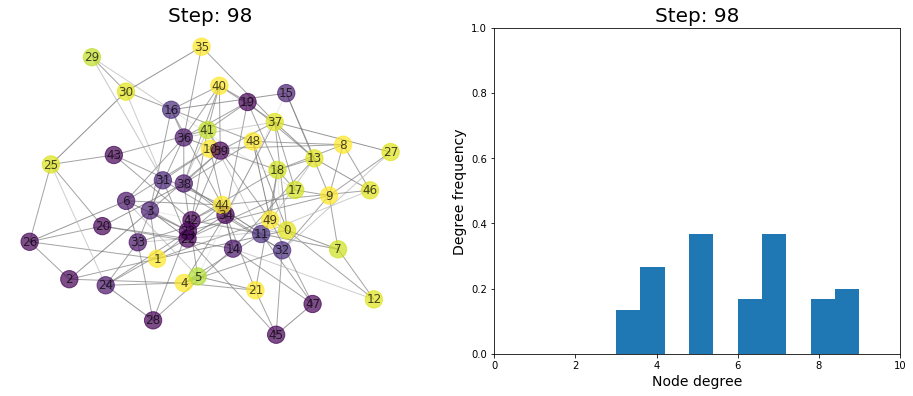

In [26]:
sim.make_animation(all_configs)

In [3]:
class LocalAnalysis():
    def __init__(self, alpha = 0.03, beta = 0.3, gamma = 4, difference = 1, weight = 0.5):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        #initialize the network of 2 nodes and 1 edge:
        self.config = nx.erdos_renyi_graph(2,1)
        
        for edge in self.config.edges:
            self.config.edges[edge]['weight'] = weight
        #Assign the opinions so that the opinion difference is "difference" initiated
        self.config.nodes[0]['opinion'] = difference
        self.config.nodes[1]['opinion'] = 0
            
        #Assign the charisma for each node. As the probability of having charisma is 50/50 (used in simulation),
        #in the local analysis, one node will have charisma of 1, and the other node will have charisma of 2. 
        self.config.nodes[0]['charisma'] = 2 #High impact on opinion difference and weight
        self.config.nodes[1]['charisma'] = 1 #No impact on opinion difference and weight
                 
    def update(self):
        edge = (0,1)
        weight = self.config.edges[edge]['weight']
        opinions = [self.config.nodes[node]['opinion'] for node in edge]
        charismas = [self.config.nodes[node]['charisma'] for node in edge]

        for i in [0, 1]:
            #update the opinion of each node in the random edge.
            #the opinion change for one node (i) is dependent on the charistma of the other node (1-i)
            self.config.nodes[edge[i]]['opinion'] = (
                opinions[i] + charismas[1-i]*self.alpha*weight*(opinions[1-i] - opinions[i]))

        #update the weight between two nodes:
        if 1-self.gamma*abs(opinions[0] - opinions[1]) > 0:
            #If the relationship is supposed to be stronger, the charisma accelerates that increase:
            #this impact is shown in the coefficient 2
            self.config.edges[edge]['weight'] = (
                weight + 2*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
        else: 
            #if the relationship is supposed to be weaker, the charisma slows down that decrease:
            #this impact is shown in the coefficient 1/2
            self.config.edges[edge]['weight'] = (
                weight + 1/2*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
        
        #remove weak connections:
        if self.config.edges[edge]['weight'] < 0.05:
            self.config.edges[edge]['weight'] = 0

In [4]:
def monitor_variable(sim, init_diff, init_weight):
    """
    Run simulation of the network (of two nodes) to trace the opinion differece and weight.
    """
    result = [[init_diff, init_weight]] 
    for _ in range(300):
        sim.update()
        #Monitor the opinion difference and the weight:
        new_diff = abs(sim.config.nodes[0]['opinion'] - sim.config.nodes[1]['opinion'])
        new_weight = sim.config.edges[(0,1)]['weight']
        
        result.append([new_diff, new_weight])
    return result

In [5]:
def draw_vector_field(alpha, beta, gamma):
    """
    Return the gradient of opinion difference and weight at each point in the plot
    """
    for x in np.linspace(0,1,10):
        for y in np.linspace(0,1,10):
            dx = -3*alpha*y*x
            dy = 2*beta*y*(1-y)*(1-gamma*x) if 1-gamma*x > 0 else  1/2*beta*y*(1-y)*(1-gamma*x)
            plt.arrow(x,y, dx, dy, head_width=0.01, alpha = 0.9)

In [105]:
class ModifiedSocialDynamics():
    def __init__(self, size = 50, alpha = 0.03, beta = 0.3, gamma = 4, prob_new_edge = 0.01):
        """
        Size is the number of nodes in the network
        alpha is the rate at which a node adjust its opinion to get closer
            to its neighbor. 
            
        beta is the rate at which the weight of an edge changes in response
            to the opinion change. 
            
        gamma is the pickiness of a node. If the node difference is greater
            than 1/gamma, the edge weight will decrease. 
        """
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.prob_new_edge = prob_new_edge
        
        #initialize the network configuration:
        self.config = nx.watts_strogatz_graph(size, 5, 0.5)

        #the initial weight of all edges is 0.5
        for edge in self.config.edges:
            self.config.edges[edge]['weight'] = 0.5
        #randomize the opinions in nodes between 0 and 1:
        for node in self.config.nodes:
            self.config.nodes[node]['opinion'] = random.randint(0, 1)
        #assign the charisma for each node in the network:
        for node in self.config.nodes:
            if random.random() < 0.5:
                self.config.nodes[node]['charisma'] = 2 #High impact on opinion difference and weight
            else:
                self.config.nodes[node]['charisma'] = 1 #No impact on opinion difference and weight
                
        self.layout = nx.spring_layout(self.config)
        self.step = 0
        self.converge = False
        self.split = False
        
    def display(self, ax='None', return_ax=False):
        """
        Draw the network
        """
        if ax=='None':
            fig,ax = plt.subplots()
            
        self.layout = nx.spring_layout(self.config, pos = self.layout, iterations = 5)
        
        nx.draw(
            self.config, pos = self.layout,
            node_color = [self.config.nodes[i]['opinion'] for i in self.config.nodes], with_labels = True,
            edge_color = [self.config.edges[edge]['weight'] for edge in self.config.edges],
            edge_cmap = plt.cm.binary, edge_vmin = 0, edge_vmax = 1,
            alpha = 0.7, vmin = 0, vmax = 1, ax=ax)
        ax.set_title("Step: " + str(self.step))
        
        if return_ax:
            return ax
        
    def check_converge(self):
        """
        Check if the network is converged or not.
        The result will show in self.converge attribute.
        A network is converged if the largest opinion difference in the network is less than 0.1
        """
        opinions = [self.config.nodes[node]['opinion'] for node in self.config.nodes]
        if max(opinions) - min(opinions) < 0.1:
            self.converge = True
        else:
            self.converge = False
            
    def check_split(self):
        """
        Check if the network is splitted into two clusters or not.
        The result will show in self.split attribute. 
        A network is split if the number of extreme edges - the edges that connect two extreme ideas,
        is less than 1% of the total number of edges.
        """
        
        extreme_edges = [] #The edges that connect two extremes ideas (opinion difference >= 0.5)
        for edge in self.config.edges:
            if abs(self.config.nodes[edge[0]]['opinion'] - self.config.nodes[edge[1]]['opinion']) >= 0.5:
                extreme_edges.append(edge)
        if len(extreme_edges)/len(self.config.edges) < 0.01:
            self.split = True
        else:
            self.split = False
                
    def update(self):
        if random.uniform(0, 1) < self.prob_new_edge:
            #Create a new edge with weight 0.5 between two unconnected nodes:
            nodes = list(self.config.nodes)
            count = 0 #Use count to avoid infinite loop
            while count < 1000:
                new_edge = np.random.choice(nodes, 2)
                #condition 1: the edge must be new:
                cond1 = new_edge not in self.config.edges
                #condiion2: the new edge connects two not-signficant ideas
                cond2 = abs(self.config.nodes[new_edge[0]]['opinion'] - self.config.nodes[new_edge[1]]['opinion']) < 0.5
                if cond1 and cond2:
                    break
                count += 1
            #Only append valid result, instead of the last result of the iteration
            if count < 1000:
                self.config.add_edge(new_edge[0], new_edge[1], weight = 0.5)
            
        else:
            #select a random edge and update node opinions and edge weight:
            edge = random.choice(list(self.config.edges))
            weight = self.config.edges[edge]['weight']
            opinions = [self.config.nodes[node]['opinion'] for node in edge]
            charismas = [self.config.nodes[node]['charisma'] for node in edge]
            
            for i in [0, 1]:
                #update the opinion of each node in the random edge.
                #the opinion change for one node (i) is dependent on the charistma of the other node (1-i)
                self.config.nodes[edge[i]]['opinion'] = (
                    opinions[i] + charismas[1-i]*self.alpha*weight*(opinions[1-i] - opinions[i]))
                
            #update the weight between two nodes after the opinion change
            if 1-self.gamma*abs(opinions[0] - opinions[1]) > 0:
                #If the relationship is supposed to be stronger, the charisma accelerates that increase:
                #this impact is shown in the coefficient (max(charismas))
                self.config.edges[edge]['weight'] = (
                    weight + max(charismas)*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
            else: 
                #if the relationship is supposed to be weaker, the charisma slows down that decrease:
                #this impact is shown in the coefficient 1/(max(charismas))
                self.config.edges[edge]['weight'] = (
                    weight + 1/(max(charismas))*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
            #remove weak connections:
            if self.config.edges[edge]['weight'] < 0.05:
                self.config.remove_edge(*edge)
        self.step += 1
        
    def make_animation(self, config_array, time_array, layout_array, video_name='None'):
        """
        """
        fig, axes = plt.subplots(ncols=2, figsize=(16,6))

        def update_frame(i):
            time = time_array[i]
            config = config_array[i]
            
            ax = axes[0]
            ax.clear()
            ax.set_title(f'Step: {time}', fontsize=20)
            ax.set_xticks([])
            ax.set_yticks([])
            nx.draw(
                config, pos=layout_array[i], with_labels = True,
                node_color = [config.nodes[i]['opinion'] for i in config.nodes],
                edge_color = [config.edges[edge]['weight'] for edge in config.edges],
                edge_cmap = plt.cm.binary, edge_vmin = 0, edge_vmax = 1,
                alpha = 0.7, vmin = 0, vmax = 1, ax=ax)

            ax2 = axes[1]
            ax2.clear()
            ax2.set_title(f'Step: {time}', fontsize=20)
            ax2.set_xlim((-0.1,1.1))
            #ax2.set_ylim((0,1))
            ax2.set_yticks([])
            ax2.set_xlabel('Opinion', fontsize=14)
            ax2.set_ylabel('Opinion frequency', fontsize=14)
            opinions = [config.nodes[node]['opinion'] for node in config.nodes]
            im = ax2.hist(opinions, density=True, bins=np.linspace(0, 1, 20))
            return im, 

        animation = anim.FuncAnimation(fig, update_frame, frames=range(0,len(time_array)-1), blit=False)
        animation.save(f'Results/{video_name}.gif', fps=3, dpi=160)
        del animation

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


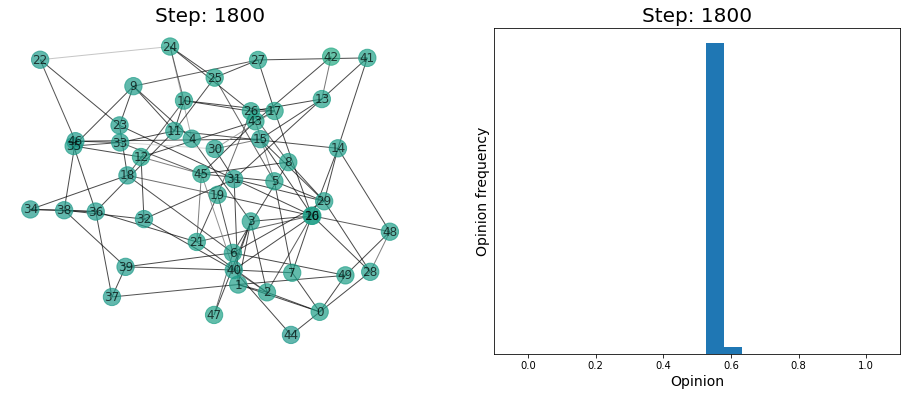

In [106]:
sim = ModifiedSocialDynamics(alpha=0.2)
config_array = []
time_array = []
layout_array = []

for i in range(2000):
    sim.update()
    if i%100 == 0:
        config_array.append(copy.deepcopy(sim.config))
        layout_array.append(nx.spring_layout(sim.config, pos=sim.layout, iterations=5))
        time_array.append(i)
        
sim.make_animation(config_array=config_array, time_array=time_array, layout_array=layout_array,
                   video_name='converged_network')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


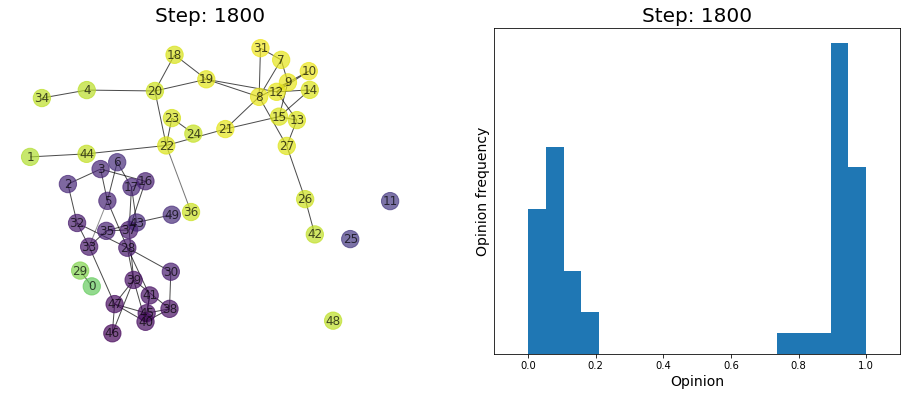

In [94]:
sim = ModifiedSocialDynamics(alpha=0.02)
config_array = []
time_array = []
layout_array = []

for i in range(2000):
    sim.update()
    if i%100 == 0:
        config_array.append(copy.deepcopy(sim.config))
        layout_array.append(nx.spring_layout(sim.config, pos=sim.layout, iterations=5))
        time_array.append(i)
        
sim.make_animation(config_array=config_array, time_array=time_array, layout_array=layout_array,
                   video_name='split_network')